# Tiny NeRF

In [1]:
import os, sys
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Optional

In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load data and visualize

In [7]:
data = np.load('tiny_nerf_data.npz')
images = data['images'] # (N_views, H, W, 3)
poses = data['poses'] # (N_views, 4, 4)
focal = data['focal'] # () in pixels
print(images.shape, poses.shape, focal)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


Device is cpu


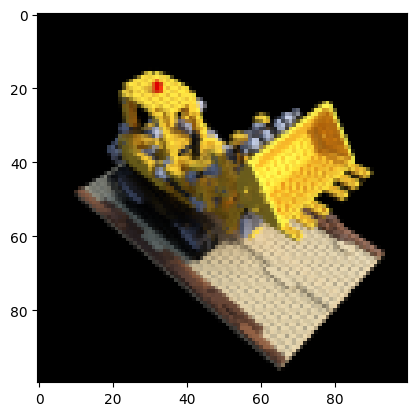

In [8]:
height, width = images.shape[1:3]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
      device = torch.device('mps')

device = torch.device('cpu')

images = torch.from_numpy(images).to(device, dtype=torch.float32)
poses = torch.from_numpy(poses).to(device, dtype=torch.float32)
focal = torch.tensor(focal).to(device, dtype=torch.float32)

test_img, test_pose = images[101], poses[101]
images = images[:100]
poses = poses[:100]

print(f'Device is {device}')
plt.imshow(test_img.cpu().numpy())
plt.show()

## Helper Functions

In [27]:
def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> (torch.Tensor, torch.Tensor):
    i, j = torch.meshgrid(tensor1, tensor2)
    return i.transpose(-1, -2), j.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    dim = -1
    cumprod = torch.cumprod(tensor, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.0

    return cumprod

## Positional Encoding

In [28]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True
) -> torch.Tensor:
    encoding = [tensor] if include_input else []

    for i in range(num_encoding_functions):
        for fn in [torch.sin, torch.cos]:
            encoding.append(fn(2.0**i * tensor))

    return torch.cat(encoding, dim=-1)

In [29]:
# testing posenc
x = torch.linspace(-1., 1., 10)
print(x)
positional_encoding(x).shape

tensor([-1.0000, -0.7778, -0.5556, -0.3333, -0.1111,  0.1111,  0.3333,  0.5556,
         0.7778,  1.0000])


torch.Size([130])

## Create model

In [12]:
class NeRF(torch.nn.Module):
    def __init__(self, D=8, W=256):
        super(NeRF, self).__init__()
        self.layer_1 = torch.nn.Linear(3 + 3 * 2 * D, W)

        self.layer_2 = torch.nn.Linear(W, W)
        self.layer_3 = torch.nn.Linear(W, W)

        self.layer_4 = torch.nn.Linear(W, 4)
        self.relu = torch.nn.functional.relu

        self.model = torch.nn.Sequential(
            self.layer_1,
            self.relu,
            self.layer_2,
            self.relu,
            self.layer_3,
            self.relu,
            self.layer_4,
        )

    def forward(self, pts):
        return self.model(pts)

In [13]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.
  
  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

In [14]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".
  
  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

## Dataloader

In [15]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Volumetric Rendering

In [16]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  
  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

## Visualize Rays

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_rays(rays_o, rays_d, title):
    rays_o = rays_o.cpu().numpy()
    rays_d = rays_d.cpu().numpy()

    # Show the origins as big red dots
    fig = go.Figure(data=[go.Scatter3d(
        x=rays_o[:,0], y=rays_o[:,1], z=rays_o[:,2],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            opacity=0.8
        )
    )])

    # Show the rays as short line segments
    # fig.add_trace(go.Scatter3d(
    #     x=rays_o[:,0] + rays_d[:,0],
    #     y=rays_o[:,1] + rays_d[:,1],
    #     z=rays_o[:,2] + rays_d[:,2],
    #     mode='lines',
    #     line=dict(
    #         color='red',
    #         width=2
    #     )
    # ))

    fig.update_layout(
        title=title,
        margin=dict(r=20, l=10, b=10, t=10))
    
    fig.show()

# plot the test rays
rays_o, rays_d = get_rays(height, width, focal, test_pose)
print(rays_o.shape, rays_d.shape)
plot_rays(rays_o, rays_d, 'Test Rays')

## Train

In [17]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):
  
  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)
  
  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/anaconda3/envs/nerf/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.18034760653972626


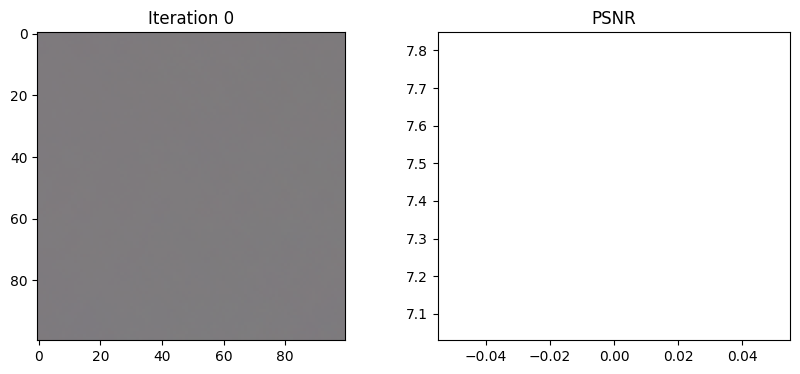

 10%|█         | 100/1000 [00:58<08:36,  1.74it/s]

Loss: 0.028566088527441025


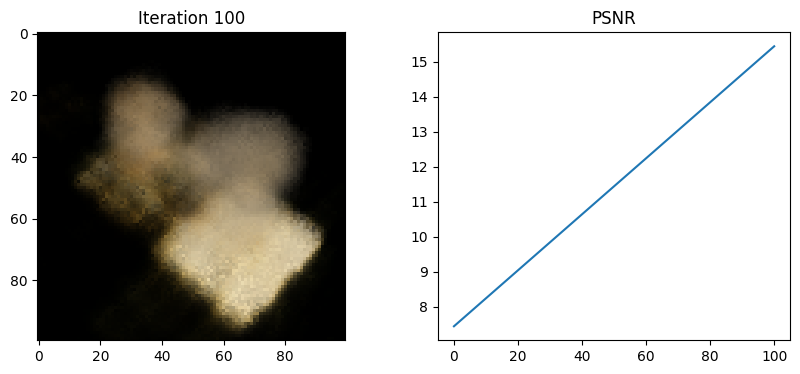

 20%|██        | 200/1000 [01:56<08:09,  1.63it/s]

Loss: 0.10408719629049301


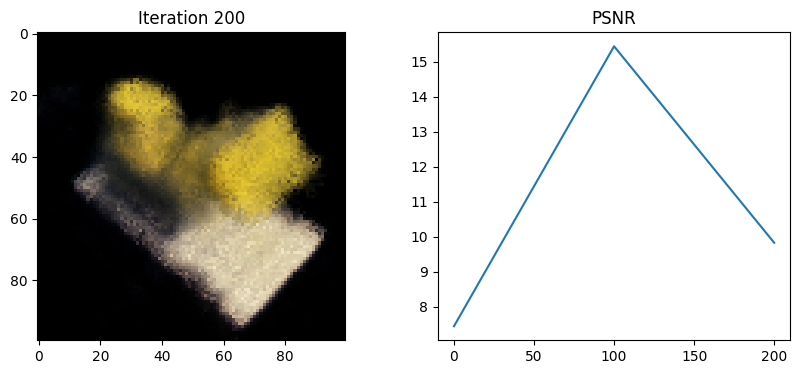

 30%|███       | 300/1000 [02:52<06:27,  1.81it/s]

Loss: 0.10474678874015808


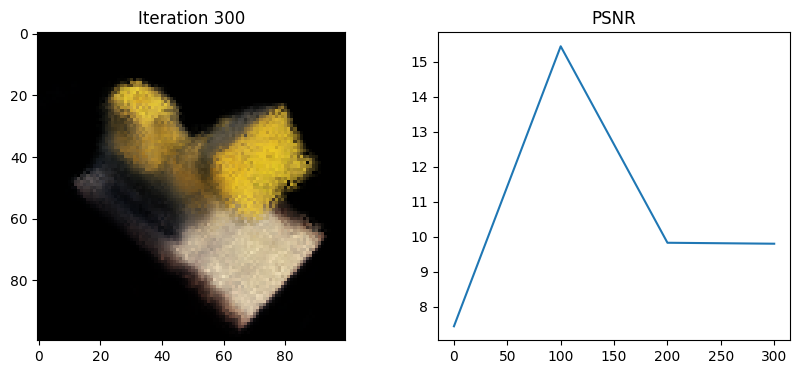

 40%|████      | 400/1000 [03:47<05:28,  1.83it/s]

Loss: 0.07267912477254868


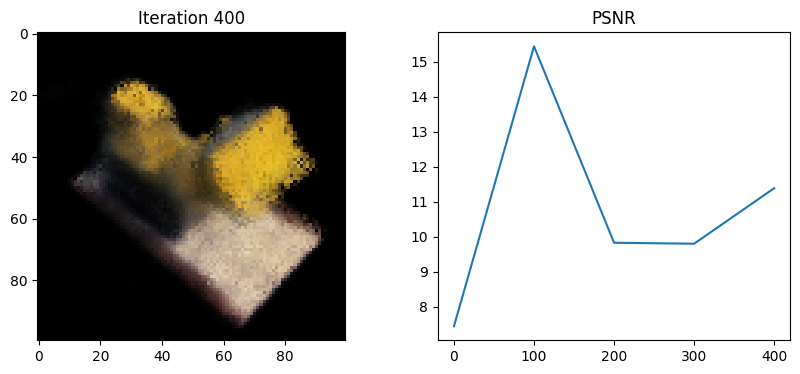

 50%|█████     | 500/1000 [04:44<04:39,  1.79it/s]

Loss: 0.05557858943939209


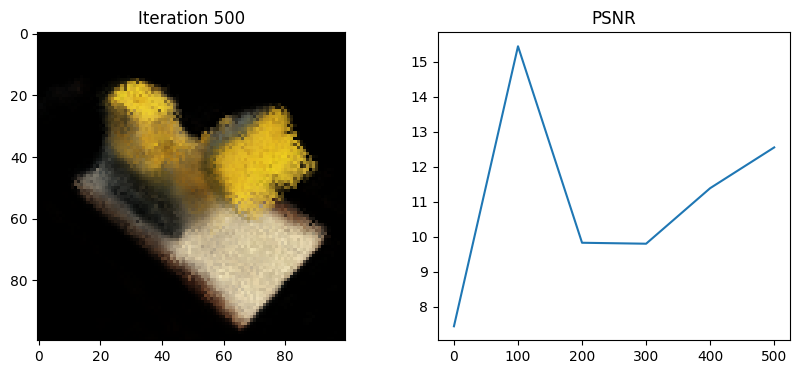

 60%|██████    | 600/1000 [05:40<03:35,  1.85it/s]

Loss: 0.10752877593040466


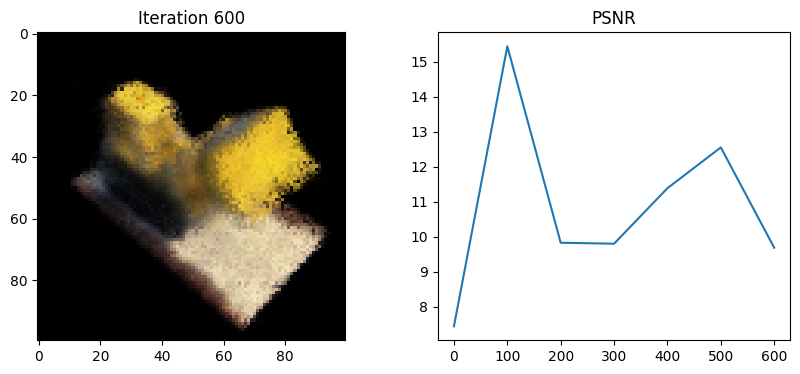

 70%|███████   | 700/1000 [06:35<02:43,  1.83it/s]

Loss: 0.09973771125078201


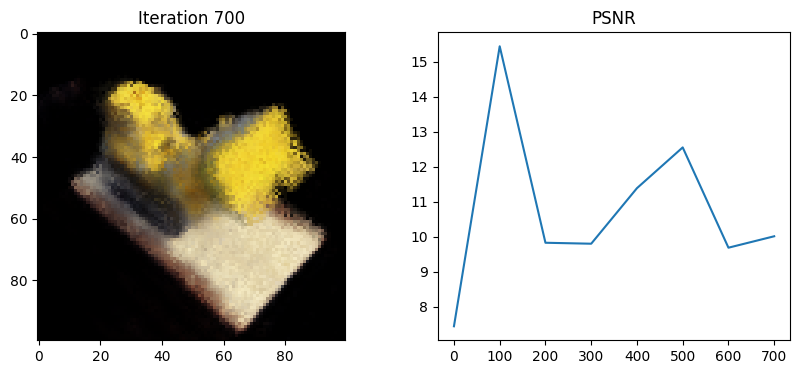

 80%|████████  | 800/1000 [07:30<01:47,  1.86it/s]

Loss: 0.09713629633188248


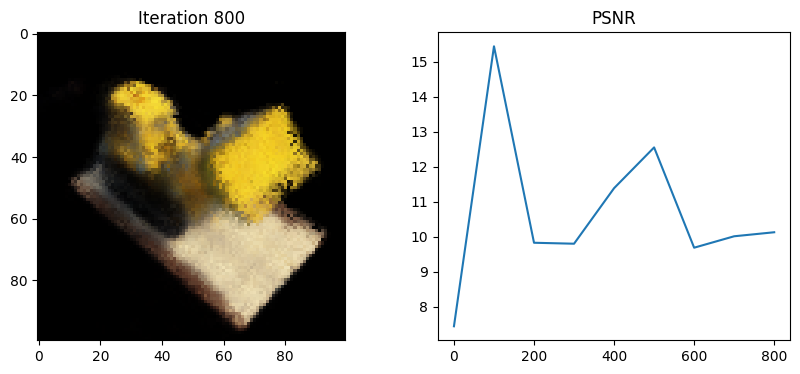

 90%|█████████ | 900/1000 [08:26<00:54,  1.84it/s]

Loss: 0.06711653620004654


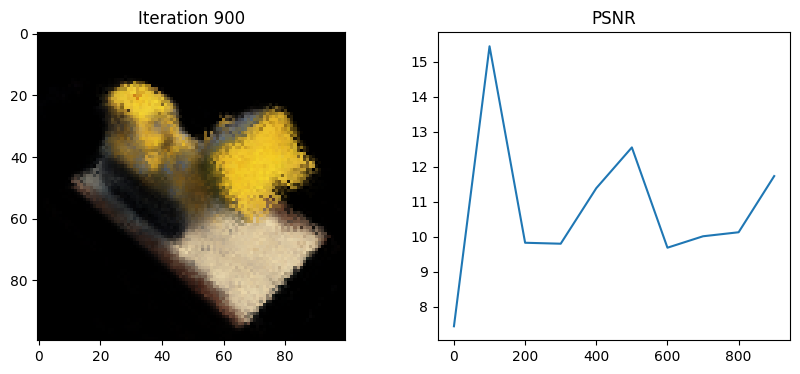

100%|██████████| 1000/1000 [09:21<00:00,  1.78it/s]

Done!


In [18]:
"""
Parameters for TinyNeRF training
"""
near_thresh = 2.
far_thresh = 6.

# Number of functions used in the positional encoding (Be sure to update the 
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = NeRF(D=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in tqdm(range(num_iters)):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = poses[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal,
                                             test_pose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)
    
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

## Test the model

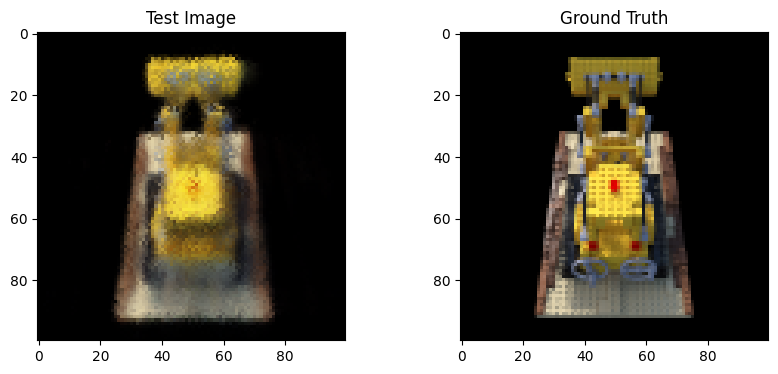

In [21]:
test_image = torch.from_numpy(data["images"][102]).to(device)
test_pose = torch.from_numpy(data["poses"][102]).to(device)
test_focal = torch.tensor(data["focal"]).to(device)

with torch.no_grad():
    rgb_predicted = run_one_iter_of_tinynerf(
        height,
        width,
        test_focal,
        test_pose,
        near_thresh,
        far_thresh,
        depth_samples_per_ray,
        encode,
        get_minibatches,
    )

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(rgb_predicted.detach().cpu().numpy())
plt.title(f"Test Image")
plt.subplot(122)
plt.imshow(test_image.detach().cpu().numpy())
plt.title(f"Ground Truth")
plt.show()